In [53]:
import numpy as np
from os.path import join
from scipy.linalg import eigh
import matplotlib.pyplot as plt

In [54]:
# ============================
# DATA LOADING
# ============================
data = np.load("/home/sakie/Desktop/repos/Classifier-for-Numbers-0-1-2-Statistical-Machine-Learning-/train_data/dataSet.npz")
flattenImages = data["images"]      # Expect shape (300, 784)
labels = data["labels"]

test = np.load("/home/sakie/Desktop/repos/Classifier-for-Numbers-0-1-2-Statistical-Machine-Learning-/train_data/testSet.npz")
testImages = test["images"]         # Expect shape (300, 784) similar to flattenImages
testLabels = test["labels"]

# (Optional reshaping if needed)
# flattenImages = flattenImages.reshape(300,784)
# testImages = testImages.reshape(numTest,784)

# ============================
# (Old) CLASS STATISTICS (for reference)
# ============================
priors = [1/3, 1/3, 1/3]
means = np.zeros((3,784), dtype=np.float64)
genMean = np.zeros((1,784), dtype=np.float64)

for idx in range(300):
    if labels[idx] == 0:
        means[0] += flattenImages[idx]
    elif labels[idx] == 1:
        means[1] += flattenImages[idx]
    elif labels[idx] == 2:
        means[2] += flattenImages[idx]
    genMean += flattenImages[idx]

means = means / 100.0
genMean = genMean / 300.0

# (Centralised matrices & per-class covariance are computed below in our helper functions.)

def calculateMeanAndCovariance(dataMatrix):
    nSamples = dataMatrix.shape[0]
    meanVec = np.mean(dataMatrix, axis=0)
    centeredData = dataMatrix - meanVec
    covMatrix = np.dot(centeredData.T, centeredData) / (nSamples - 1)
    return meanVec, covMatrix

The dimension chosed for PCA is 80 for a variance of 0.95
LDA after PCA Test Accuracy: 97.67%
QDA after PCA Test Accuracy: 99.00%
LDA on PCA Training Accuracy: 99.00%
QDA on PCA Training Accuracy: 100.00%


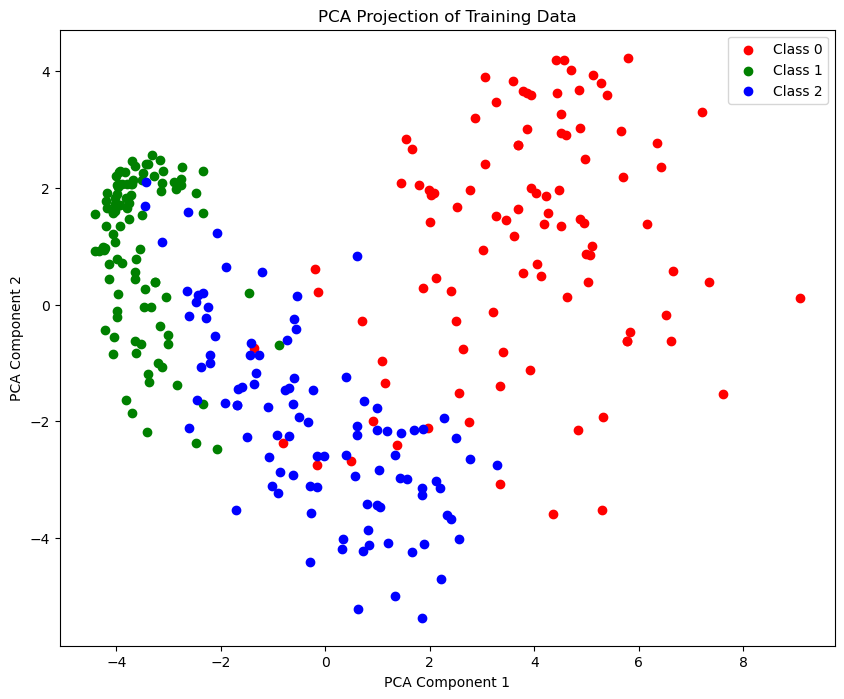

The dimension chosed for PCA is 49 for a variance of 0.9
LDA after PCA Test Accuracy for 90% Variance: 96.67%
QDA after PCA Test Accuracy 90% Variance: 98.33%
LDA on PCA Training Accuracy for 90% Variance: 97.67%
QDA on PCA Training Accuracy for 90% Variance: 100.00%


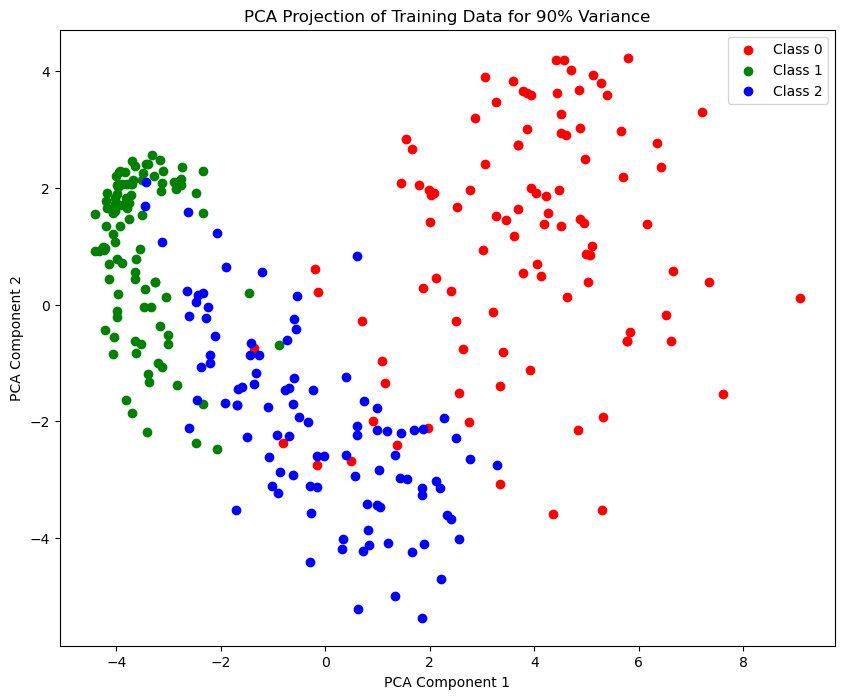

LDA after FDA Test Accuracy: 94.00%
QDA after FDA Test Accuracy: 95.33%


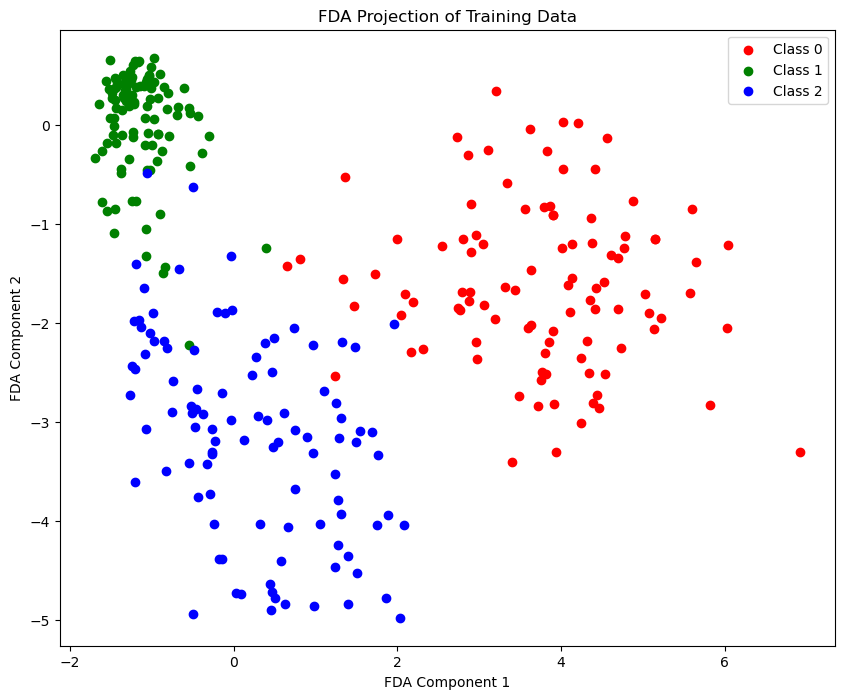

In [ ]:
# ============================
# COMPLETE CLASSIFIERS (LDA & QDA)
# ============================
def completeLinearDiscriminantAnalysis(xTrain, yTrain, xTest, classes=[0, 1, 2]):
    """
    Complete Linear Discriminant Analysis (LDA) classifier.
    Computes a pooled covariance matrix from the training data.
    """
    xTrain = np.array(xTrain)
    yTrain = np.array(yTrain).flatten()
    xTest  = np.array(xTest)
    m, n = xTrain.shape
    
    # Compute class priors and means from training data
    priors = {c: np.mean(yTrain == c) for c in classes}
    means  = {c: np.mean(xTrain[yTrain == c], axis=0) for c in classes}
    
    # Compute pooled covariance matrix
    pooledCov = sum(np.dot((xTrain[yTrain == c] - means[c]).T, (xTrain[yTrain == c] - means[c]))
                    for c in classes) / m
    invCov = np.linalg.inv(pooledCov)
    
    # Classify each test sample using the LDA discriminant function
    yPred = []
    for x in xTest:
        scores = {c: np.dot(x, invCov @ means[c]) - 0.5 * np.dot(means[c], invCov @ means[c]) + np.log(priors[c])
                  for c in classes}
        yPred.append(max(scores, key=scores.get))
    return np.array(yPred)

def completeQuadraticDiscriminantAnalysis(xTrain, yTrain, xTest, classes=[0, 1, 2]):
    """
    Complete Quadratic Discriminant Analysis (QDA) classifier.
    Computes a separate covariance matrix for each class.
    """
    xTrain = np.array(xTrain)
    yTrain = np.array(yTrain).flatten()
    xTest  = np.array(xTest)
    m, n = xTrain.shape
    
    priors = {c: np.mean(yTrain == c) for c in classes}
    means, invCovs, logDets = {}, {}, {}
    for c in classes:
        dataC = xTrain[yTrain == c]
        means[c] = np.mean(dataC, axis=0)
        covC = np.dot((dataC - means[c]).T, (dataC - means[c])) / dataC.shape[0]
        covC += np.eye(n) * 1e-3  # Regularization for numerical stability
        invCovs[c] = np.linalg.inv(covC)
        logDets[c] = np.log(np.linalg.det(covC))
    
    yPred = []
    for x in xTest:
        scores = {c: -0.5 * ((x - means[c]).T @ invCovs[c] @ (x - means[c]))
                    - 0.5 * logDets[c]
                    + np.log(priors[c])
                  for c in classes}
        yPred.append(max(scores, key=scores.get))
    return np.array(yPred)

# ============================
# PCA FUNCTIONS
# ============================
def performPca(data, varThresh):
    mu = np.mean(data, axis=0)
    dataCentered = data - mu

    sigma = np.dot(dataCentered.T, dataCentered) / (data.shape[0] - 1)

    # Perform eigen-decomposition
    eigenValues, eigenVectors = np.linalg.eigh(sigma)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    
    # Determine the number of components needed using a for loop
    totalVariance = np.sum(eigenValues)
    cumulativeVariance = 0.0
    numComponents = 0
    for ev in eigenValues:
        cumulativeVariance += ev / totalVariance
        numComponents += 1
        if cumulativeVariance >= varThresh:
            break

    print(f'The dimension chosed for PCA is {numComponents} for a variance of {varThresh}')
    Up = eigenVectors[:, :numComponents]
    transformed = np.dot(dataCentered, Up)

    return transformed, Up, mu

def transformPca(data, Up, mu):
    return np.dot(data - mu, Up)

# ============================
# FDA FUNCTIONS
# ============================
def performFdaTraining(xTrain, y, classes=[0, 1, 2]):
    """
    Perform Fisher's Discriminant Analysis (FDA) on the training data.
    Returns the FDA projection matrix (with at most C-1 components).
    """
    m, n = xTrain.shape
    overallMean = np.mean(xTrain, axis=0)
    sW = np.zeros((n, n))
    sB = np.zeros((n, n))
    for c in classes:
        xC = xTrain[y == c]
        nC = xC.shape[0]
        meanC = np.mean(xC, axis=0)
        diff = (meanC - overallMean).reshape(-1, 1)
        sB += nC * np.dot(diff, diff.T)
        centered = xC - meanC
        sW += np.dot(centered.T, centered)
    sW += 1e-6 * np.eye(n)
    eigVals, eigVecs = np.linalg.eigh(np.linalg.pinv(sW) @ sB)
    idx = np.argsort(eigVals)[::-1]
    eigVecs = eigVecs[:, idx]
    # For 3 classes, FDA can provide up to 2 components.
    W = eigVecs[:, :len(classes)-1]
    return W

# ============================
# HELPER FOR ACCURACY
# ============================
def computeAccuracy(yTrue, yPred):
    return np.mean(yTrue == yPred) * 100

# ============================================================
# 1) PCA + LDA / QDA CLASSIFICATION
# ============================================================
pcaVar = 0.95
trainingPca, UpPca, muPca = performPca(flattenImages, pcaVar)
testPca = transformPca(testImages, UpPca, muPca) # Just to get the training set

# Classify using LDA and QDA on PCA-transformed data
ldaPcaPred = completeLinearDiscriminantAnalysis(trainingPca, labels, testPca, classes=[0,1,2])
qdaPcaPred = completeQuadraticDiscriminantAnalysis(trainingPca, labels, testPca, classes=[0,1,2])

accLdaPca = computeAccuracy(testLabels, ldaPcaPred)
accQdaPca = computeAccuracy(testLabels, qdaPcaPred)

print(f"LDA after PCA Test Accuracy: {accLdaPca:.2f}%")
print(f"QDA after PCA Test Accuracy: {accQdaPca:.2f}%")

ldaPcaTrainPred = completeLinearDiscriminantAnalysis(trainingPca, labels, trainingPca, classes=[0,1,2])
qdaPcaTrainPred = completeQuadraticDiscriminantAnalysis(trainingPca, labels, trainingPca, classes=[0,1,2])

accLdaPcaTrain = computeAccuracy(labels, ldaPcaTrainPred)
accQdaPcaTrain = computeAccuracy(labels, qdaPcaTrainPred)

print(f"LDA on PCA Training Accuracy: {accLdaPcaTrain:.2f}%")
print(f"QDA on PCA Training Accuracy: {accQdaPcaTrain:.2f}%")


UniqueLabels = np.unique(labels)
Colors = ['red', 'green', 'blue']
plt.figure(figsize=(10, 8))
for i, label in enumerate(UniqueLabels):
    indices = np.where(labels == label)[0]
    plt.scatter(trainingPca[indices, 0], trainingPca[indices, 1],
                color=Colors[i], label=f"Class {label}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Training Data")
plt.legend()
plt.savefig('PCA_PLT.png')
plt.show()


pcaVar = 0.90
trainingPca, UpPca, muPca = performPca(flattenImages, pcaVar)
testPca = transformPca(testImages, UpPca, muPca) # Just to get the training set

# Classify using LDA and QDA on PCA-transformed data
ldaPcaPred = completeLinearDiscriminantAnalysis(trainingPca, labels, testPca, classes=[0,1,2])
qdaPcaPred = completeQuadraticDiscriminantAnalysis(trainingPca, labels, testPca, classes=[0,1,2])

accLdaPca = computeAccuracy(testLabels, ldaPcaPred)
accQdaPca = computeAccuracy(testLabels, qdaPcaPred)

print(f"LDA after PCA Test Accuracy for 90% Variance: {accLdaPca:.2f}%")
print(f"QDA after PCA Test Accuracy 90% Variance: {accQdaPca:.2f}%")

ldaPcaTrainPred = completeLinearDiscriminantAnalysis(trainingPca, labels, trainingPca, classes=[0,1,2])
qdaPcaTrainPred = completeQuadraticDiscriminantAnalysis(trainingPca, labels, trainingPca, classes=[0,1,2])

accLdaPcaTrain = computeAccuracy(labels, ldaPcaTrainPred)
accQdaPcaTrain = computeAccuracy(labels, qdaPcaTrainPred)

print(f"LDA on PCA Training Accuracy for 90% Variance: {accLdaPcaTrain:.2f}%")
print(f"QDA on PCA Training Accuracy for 90% Variance: {accQdaPcaTrain:.2f}%")

UniqueLabels = np.unique(labels)
Colors = ['red', 'green', 'blue']
plt.figure(figsize=(10, 8))
for i, label in enumerate(UniqueLabels):
    indices = np.where(labels == label)[0]
    plt.scatter(trainingPca[indices, 0], trainingPca[indices, 1],
                color=Colors[i], label=f"Class {label}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Projection of Training Data for 90% Variance")
plt.legend()
plt.savefig('PCA_PLT_90.png')
plt.show()
# ============================================================
# 2) FDA + LDA / QDA CLASSIFICATION
# ============================================================
# Obtain the FDA projection matrix from training data
Wfda = performFdaTraining(flattenImages, labels, classes=[0,1,2])

trainingFda = np.dot(flattenImages, Wfda)
testFda = np.dot(testImages, Wfda)

ldaFdaPred = completeLinearDiscriminantAnalysis(trainingFda, labels, testFda, classes=[0,1,2])
qdaFdaPred = completeQuadraticDiscriminantAnalysis(trainingFda, labels, testFda, classes=[0,1,2])

accLdaFda = computeAccuracy(testLabels, ldaFdaPred)
accQdaFda = computeAccuracy(testLabels, qdaFdaPred)

print(f"LDA after FDA Test Accuracy: {accLdaFda:.2f}%")
print(f"QDA after FDA Test Accuracy: {accQdaFda:.2f}%")

ldaFdaTrainPred = completeLinearDiscriminantAnalysis(trainingFda, labels, trainingFda, classes=[0,1,2])
qdaFdaTrainPred = completeQuadraticDiscriminantAnalysis(trainingFda, labels, trainingFda, classes=[0,1,2])

accLdaFdaTrain = computeAccuracy(labels, ldaFdaTrainPred)
accQdaFdaTrain = computeAccuracy(labels, qdaFdaTrainPred)

print(f"LDA on FDA Training Accuracy: {accLdaFdaTrain:.2f}%")
print(f"QDA on FDA Training Accuracy: {accQdaFdaTrain:.2f}%")

UniqueLabels = np.unique(labels)
Colors = ['red', 'green', 'blue']
plt.figure(figsize=(10, 8))
for i, label in enumerate(UniqueLabels):
    indices = np.where(labels == label)[0]
    plt.scatter(trainingFda[indices, 0], trainingFda[indices, 1],
                color=Colors[i], label=f"Class {label}")
plt.xlabel("FDA Component 1")
plt.ylabel("FDA Component 2")
plt.title("FDA Projection of Training Data")
plt.legend()
plt.savefig('FDA_PLT.png')
plt.show()
